In [2]:
import xarray as xr
import numpy as np
import dask
import pandas as pd
import dask.dataframe as dd
import os
import glob

import holoviews as hv
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas

ModuleNotFoundError: No module named 'xarray'

### create cluster on HPC

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
cluster = SLURMCluster(
    job_extra_directives=["--qos standby", "partition=priority"],
    cores=2,
    memory="8GB",
    project="compacts",
    walltime="0-00:10:00",
    log_directory = "dask-worker-space/logs",
    #worker_extra_args=["--lifetime", "10m", "--lifetime-stagger", "2m"]
)

In [3]:
cluster.scale(n=32)

In [16]:
cluster.adapt(minimum=4,maximum=128)

In [4]:
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.21.1.65:8787/status,
Dashboard: http://172.21.1.65:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.21.1.65:40911,Workers: 0
Dashboard: http://172.21.1.65:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [49]:
cluster.close()

2022-09-12 13:41:31,606 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [6]:
resultsdir = "/p/projects/compacts/projects/DeMo/Damians_code/social_agent_based_modelling/data/uniform_parameters"

filename= "uniform_parameters_agent_data.csv"

data_dask = dd.read_csv(os.path.join(resultsdir,filename))

In [7]:

#neighbourhood uniformity analysis
def get_neigbours_list (id,ncols=100,nrows=100):
    #get up and down neigbour:
    up = id-100
    if up <1:
        up = up+ncols*nrows
    down=id+100
    if down >10000:
        down = down-ncols*nrows
    left = []
    right=[]
    up_down = [up,down]
    center=up_down+[id]
    for center_id in center:
        modulo_cols = center_id%ncols
        if modulo_cols==1:
            left_id = center_id-1+ncols
        else:
            left_id = center_id-1
        if modulo_cols==0:
            right_id= center_id+1-ncols
        else:
            right_id=center_id+1
        left.append(left_id)
        right.append(right_id)
    return left+up_down+right

In [7]:
#calculate cognitive dissonance
data_dask["cognitive_dissonance_signed"] = data_dask["affinityGoal"]-data_dask["affinity"]
data_dask["cognitive_dissonance"] = np.abs(data_dask["cognitive_dissonance_signed"])
#inherent decision
data_dask["inherent_decision"] = data_dask["affinityGoal"]>=0.5
data_dask.inherent_decision = data_dask.inherent_decision.replace({True: 1, False: 0})
#decision:
data_dask["decision"] = data_dask["affinity"]>=0.5
data_dask.decision = data_dask.decision.replace({True: 1, False: 0})
#satisfaction:
data_dask["satisfaction"] = data_dask["decision"]==data_dask["inherent_decision"]
data_dask.satisfaction = data_dask.satisfaction.replace({True: 1, False: 0})
#data_dask["neighbourhood_uniformity"]=data_dask["index"].apply(neighbourhood_uniformity,meta=float)

In [ ]:
final_data_lazy = data_dask[data_dask["step"]==200]
start_data_lazy = data_dask[data_dask["step"]==1]
to_be_computed=[start_data_lazy,final_data_lazy]
computed = dask.compute(to_be_computed)[0]

In [8]:
#check some timeseries of agents
seed = 7999
ids = [100,1000,2100,4000,1243,1342,1433,896,1047,2342,6543,7896,5432,212,1255,1278]
selected_data = data_dask[data_dask["seed"]==seed][data_dask["id"].isin(ids)]

In [9]:
computed_selection = selected_data.compute()
computed_selection.index = np.arange(1,len(computed_selection.index)+1,1)
computed_selection["index"]=computed_selection.index

Text(0, 0.5, 'affinity')

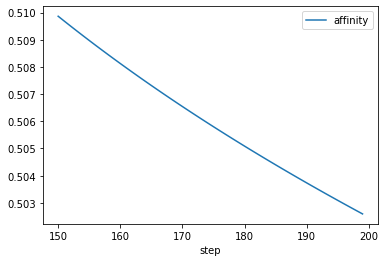

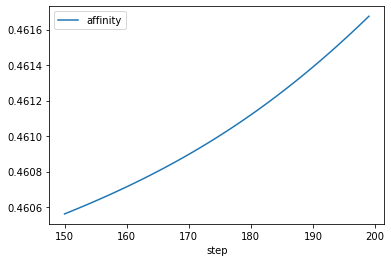

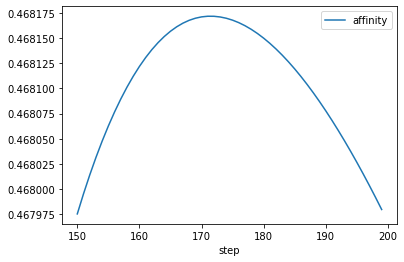

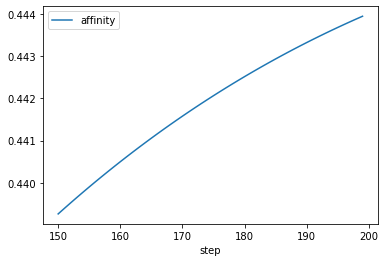

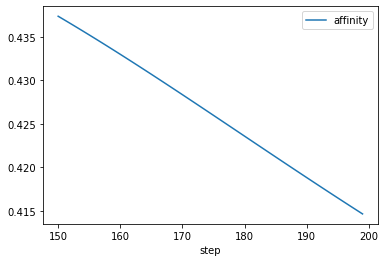

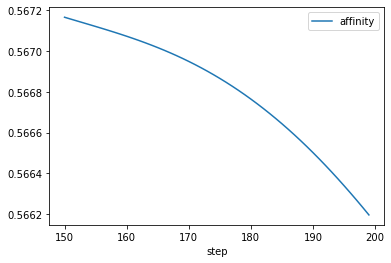

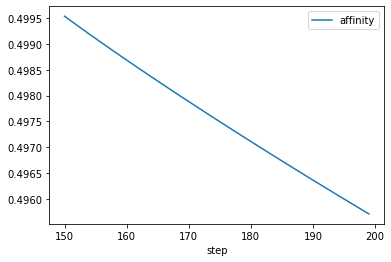

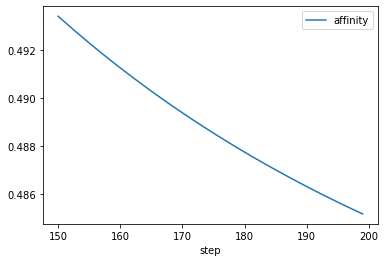

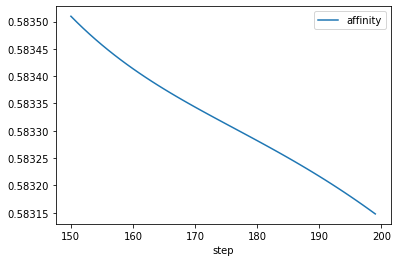

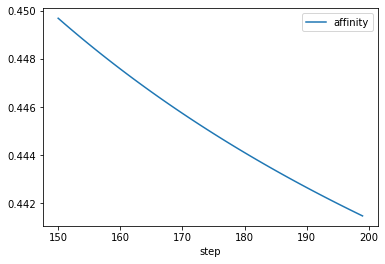

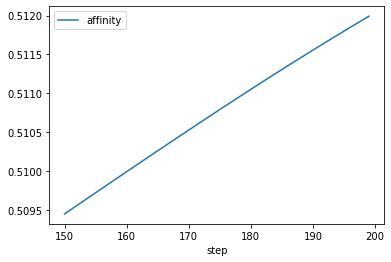

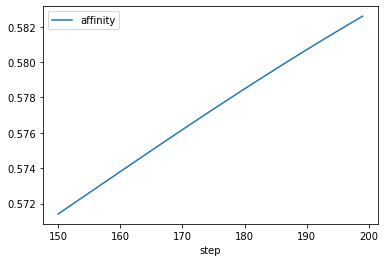

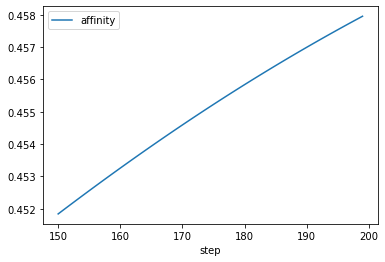

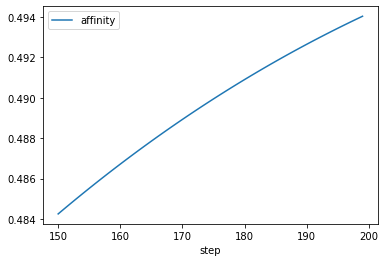

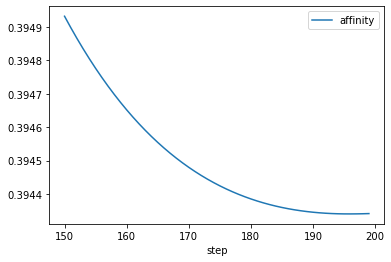

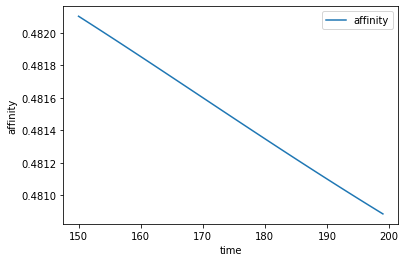

In [54]:
#import hvplot.pandas
final_times = np.arange(150,200)
computed_selection[computed_selection["step"].isin(final_times)].groupby("id").plot(x="step",y="affinity")
plt.xlabel("time")
plt.ylabel("affinity")

In [8]:
#check timeseries of last timesteps for stable state behaviour:
timesteps = np.arange(190,201)
equilibrium_data = {}
for i_time in timesteps:
    equilibrium_data[i_time] = data_dask[data_dask["step"]==i_time]

In [9]:
computed_last_timesteps = dask.compute(equilibrium_data)[0]

In [12]:
start_data = computed[0]
final_data=computed[1]

In [13]:
start_data.index = np.arange(1,len(start_data.index)+1,1)
start_data["index"]=start_data.index
final_data.index = np.arange(1,len(final_data.index)+1,1)
final_data["index"]=final_data.index
start_data["neighbours"]=start_data["id"].apply(get_neigbours_list)
final_data["neighbours"]=final_data["id"].apply(get_neigbours_list)

In [11]:
fine_bin_labels = ["[0,0.1]","(0.1,0.2]","(0.2,0.3]","(0.3,0.4]","(0.4,0.5]","(0.5,0.6]","(0.6,0.7]","(0.7,0.8]","(0.8,0.9]","(0.9,1.0]"]
for i_time in timesteps:
    computed_last_timesteps[i_time].index = np.arange(1,len(computed_last_timesteps[i_time].index)+1,1)
    computed_last_timesteps[i_time]["index"]=computed_last_timesteps[i_time].index
    computed_last_timesteps[i_time]["avantgarde_fine_binned"]= pd.cut(computed_last_timesteps[i_time]["avantgarde"],10,labels=fine_bin_labels)
    
for i_time in timesteps[1:]:
    computed_last_timesteps[i_time]["delta_affinity"]= computed_last_timesteps[i_time]["affinity"]-computed_last_timesteps[i_time-1]["affinity"] 

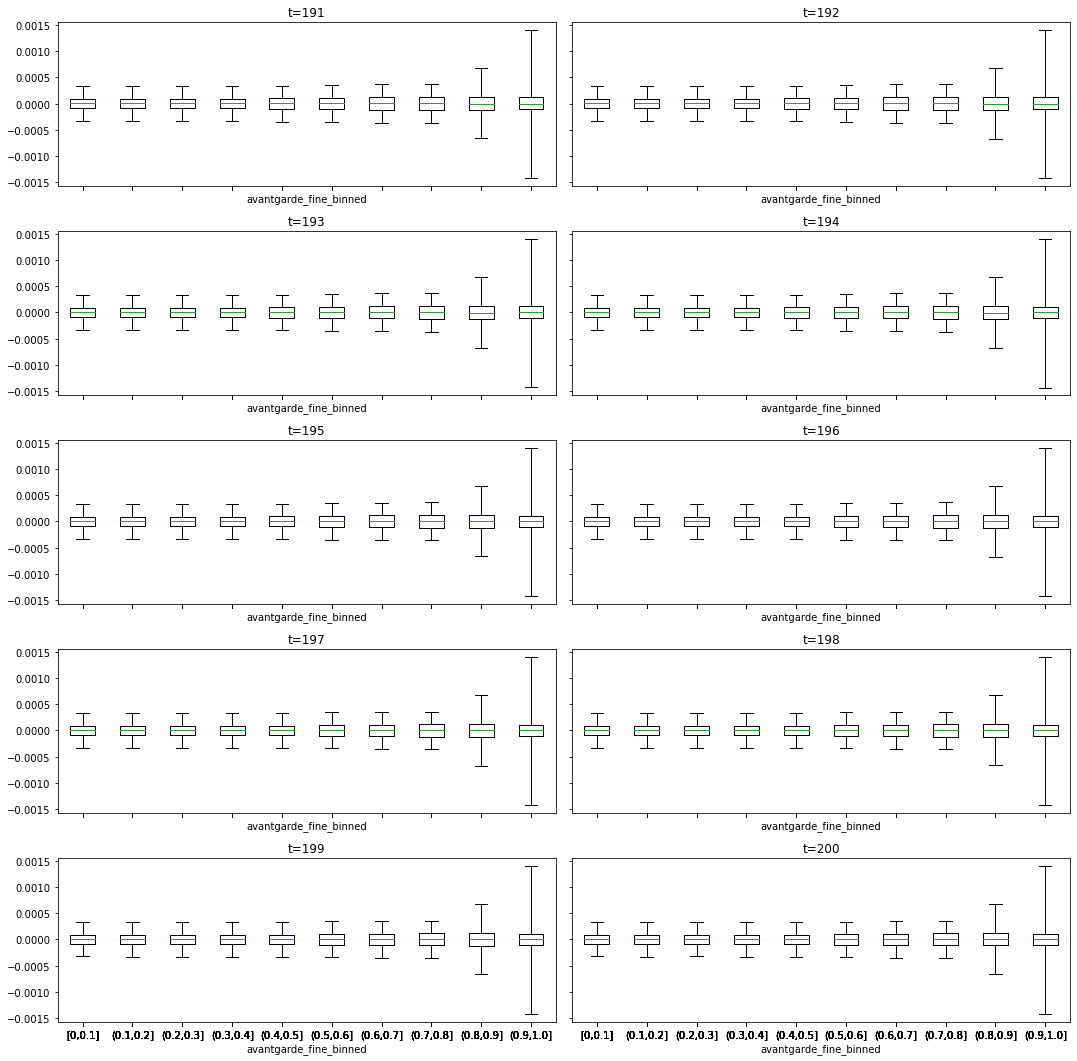

In [28]:
fig, axs = plt.subplots(5, 2,sharey=True,sharex=True,figsize=(15,15))
row_index=0
column_index=0
for i_time in timesteps[1:]:
    current_ax = axs[row_index,column_index]
    computed_last_timesteps[i_time].boxplot(ax=current_ax,by="avantgarde_fine_binned",column="delta_affinity",whis=(2.5, 97.5)
                   ,grid=False,boxprops={"color":"black"},whiskerprops={"color":"black"},showfliers=False)
    current_ax.set_title("t="+str(i_time))
    plt.suptitle("")
    column_index+=1
    if column_index==2:
        row_index+=1
        column_index=0
plt.tight_layout()
plt.savefig("figures/oscilation.pdf")

In [68]:
#figure 1: example grids initial/final choice parameter resp. decision
seed=7999
example_start = start_data[start_data.seed==7999]
example_final = final_data[final_data.seed==7999]
n_rows = 100
n_cols = 100
#get matrices of data:
start_choice_grid = np.array(example_start["affinity"]).reshape(n_rows, n_cols)
start_decision_grid = np.array(example_start["decision"]).reshape(n_rows, n_cols)
final_choice_grid = np.array(example_final["affinity"]).reshape(n_rows, n_cols)
final_decision_grid = np.array(example_final["decision"]).reshape(n_rows, n_cols)


In [37]:
#helper to keep plots as squares
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [116]:
def grid_plot(data,colormap,ax):
    grid = ax.pcolormesh(data,cmap=colormap)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    set_size(4,4,ax=ax)
    ax.set_aspect(1)
    return grid

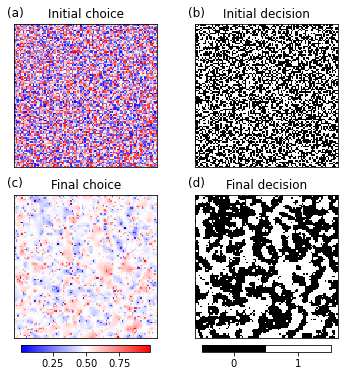

In [122]:
from matplotlib.colors import LinearSegmentedColormap
import string
#define colormaps
colors = ((0, 0, 0), (1, 1, 1))
cmap_black_white = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
cmap_continous = "bwr"

datalist = [start_choice_grid,start_decision_grid,final_choice_grid,final_decision_grid]
titles = ["Initial choice","Initial decision","Final choice","Final decision"]
fig, axs = plt.subplots(2, 2)
dataindex=0
for row in range(2):
    for col in range(2):
        ax = axs[row, col]
        if col==0:
            colormap=cmap_continous
        else:
            colormap=cmap_black_white
        grid = grid_plot(datalist[dataindex],colormap,ax)
        ax.text(-0.05, 1.05, "("+string.ascii_lowercase[dataindex]+")", transform=ax.transAxes, 
            size=12)
        ax.title.set_text(titles[dataindex])
        dataindex+=1
        if row==1:
            cax = ax.inset_axes([0.05,-0.1,0.9,0.05], transform=ax.transAxes)
            colorbar = fig.colorbar(grid, ax=axs[:, col],cax=cax, shrink=1,orientation="horizontal")
        if col==1:
            colorbar.set_ticks([0.25,0.75])
            colorbar.set_ticklabels(['0', '1'])
plt.tight_layout()
plt.savefig("figures/figure2.pdf")

In [179]:
#fig 2 - share of groups true to inherent motivation
#seperate by inherent decision
data_no = final_data[final_data["inherent_decision"]==0]
data_yes = final_data[final_data["inherent_decision"]==1]
affinity = final_data["affinity"]

#get share of satisfaction:
start_data["satisfaction"].sum()/len(start_data)*100

50.0602

In [183]:
from cycler import cycler
custom_cycler = (cycler(color=['r','m','g']))


In [211]:
def histogram(data,ax,label,color):
    histogram = data.plot.hist(ax=ax,xlim=[0,1],bins=100,alpha=0.25,weights=np.zeros_like(data) + 1. / data.size,color=color)
    ax.set_xlabel(label)
    ax.set_ylabel("Relative frequency")
    ax.axvline(0.5,ls="dashed",color="black")
    ax.axvline(np.median(data),color=color)
    return histogram

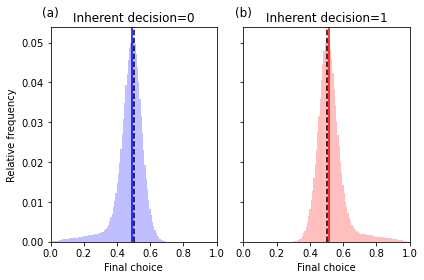

In [229]:
datalist = [data_no["affinity"],data_yes["affinity"]]
label="Final choice"
titles = ["Inherent decision=0","Inherent decision=1"]
colors=["blue","red"]
fig, axs = plt.subplots(1, 2,sharey=True)
for col in range(2):
    dataindex=col
    histogram(datalist[dataindex],axs[dataindex],label,colors[dataindex])
    axs[dataindex].text(-0.05, 1.05, "("+string.ascii_lowercase[dataindex]+")", transform=axs[dataindex].transAxes, 
            size=12)
    axs[dataindex].title.set_text(titles[dataindex])
plt.tight_layout()
plt.savefig("figures/figure3.pdf")

In [273]:
bin_labels = ["[0,0.25]","(0.25,0.5]","(0.5,0.75]","(0.75,1.0]"]
start_data["avantgarde_binned"]= pd.cut(start_data["avantgarde"],4,labels=bin_labels)
final_data["avantgarde_binned"]= pd.cut(final_data["avantgarde"],4,labels=bin_labels)
fine_bin_labels = ["[0,0.1]","(0.1,0.2]","(0.2,0.3]","(0.3,0.4]","(0.4,0.5]","(0.5,0.6]","(0.6,0.7]","(0.7,0.8]","(0.8,0.9]","(0.9,1.0]"]
start_data["avantgarde_fine_binned"]= pd.cut(start_data["avantgarde"],10,labels=fine_bin_labels)
final_data["avantgarde_fine_binned"]= pd.cut(final_data["avantgarde"],10,labels=fine_bin_labels)

In [250]:
#fig 4 - cd with respect to avantgarde bins

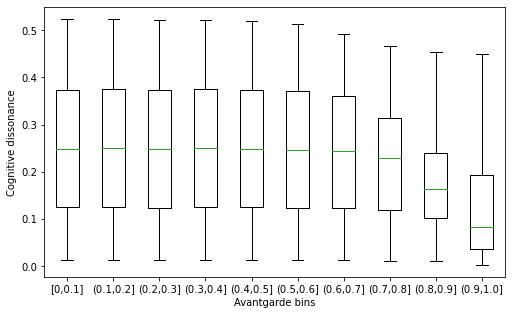

In [416]:
fig, axs = plt.subplots(1, 1,figsize=(8,5))
final_data.boxplot(ax=axs,by="avantgarde_fine_binned",column="cognitive_dissonance",whis=(2.5, 97.5)
                   ,grid=False,boxprops={"color":"black"},whiskerprops={"color":"black"},showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Avantgarde bins")
plt.ylabel("Cognitive dissonance")
plt.savefig("figures/figure5_a_draft.pdf")

In [313]:
grouped = start_data.groupby(["avantgarde_fine_binned","seed"])["cognitive_dissonance"].mean()


avantgarde_fine_binned  seed
[0,0.1]                 188     0.323621
                        216     0.313683
                        275     0.310656
                        349     0.314208
                        442     0.328032
                                  ...   
(0.9,1.0]               9433    0.326099
                        9616    0.323390
                        9695    0.326000
                        9719    0.319657
                        9992    0.326216
Name: cognitive_dissonance, Length: 990, dtype: float64

In [370]:
levels = grouped.index.get_level_values(0).categories
leveled_data = pd.DataFrame(columns=["level","mean","low_quantile","upper_quantile"])
series = [leveled_data]
for i_level in levels:
    mean = grouped[i_level].mean()
    low_quantile = grouped[i_level].quantile(0.025)
    upper_quantile = grouped[i_level].quantile(1-0.025)
    entry = pd.DataFrame.from_dict({
     "level": [i_level],
     "mean":  mean,
     "low_quantile": low_quantile,
     "upper_quantile": upper_quantile 
    })
    series.append(entry)
leveled_data = pd.concat(series,ignore_index=True)
leveled_data["mean"]= pd.to_numeric(leveled_data["mean"])
leveled_data["low_quantile"]= pd.to_numeric(leveled_data["low_quantile"])
leveled_data["upper_quantile"] = pd.to_numeric(leveled_data["upper_quantile"])

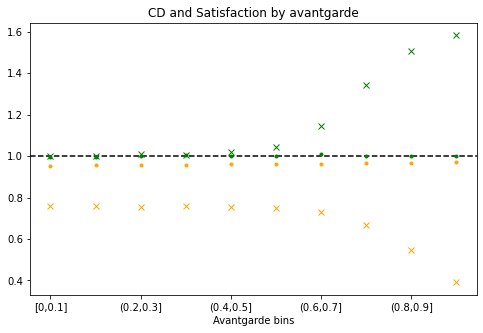

In [411]:
clr_satisfaction = "green"
clr_cd = "orange"
fig, axs = plt.subplots(1, 1,figsize=(8,5))
axs.axhline(1,color="black",ls="--")
(start_data.groupby("avantgarde_fine_binned").mean()["satisfaction"]*2).plot(ax=axs,lw=0,marker=".",color=clr_satisfaction)
(final_data.groupby("avantgarde_fine_binned").mean()["satisfaction"]*2).plot(ax=axs,lw=0,marker="x",color=clr_satisfaction)
(start_data.groupby("avantgarde_fine_binned").mean()["cognitive_dissonance"]*3).plot(ax=axs,lw=0,marker=".",color=clr_cd)
(final_data.groupby("avantgarde_fine_binned").mean()["cognitive_dissonance"]*3).plot(ax=axs,lw=0,marker="x",color=clr_cd)
plt.xlabel("Avantgarde bins")
plt.title("CD and Satisfaction by avantgarde")
plt.savefig("figures/figure5_b_draft.pdf")

In [15]:
#calculate neighbourhood uniformity:
def neighbourhood_uniformity(index,data=final_dask):
    seed = data.loc[index]["seed"]
    seed_data = data[data["seed"]==seed]
    neighbours = data.loc[index]["neighbours"].to_frame().compute()
    uniformity= (-np.abs(seed_data[seed_data.id.isin(neighbours)]["inherent_decision"]-seed_data.loc[index]["inherent_decision"]))*2+1
    return (int(np.sum(uniformity))/len(neighbours))#returns array for each seed


In [11]:
final_dask = dd.from_pandas(final_data,npartitions=100)

In [12]:
final_dask_part = final_dask[final_dask["seed"]==7999]

In [13]:
final_dask_part

,step,id,affinity,avantgarde,affinityGoal,seed,cognitive_dissonance_signed,cognitive_dissonance,inherent_decision,decision,satisfaction,index,neighbours
npartitions=100,,,,,,,,,,,,,
1,int64,int64,float64,float64,float64,int64,float64,float64,int64,int64,int64,int64,object
10001,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990001,...,...,...,...,...,...,...,...,...,...,...,...,...
1000000,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
final_dask_part["neighbourhood_uniformity"]=final_dask_part["index"].apply(neighbourhood_uniformity,meta=float)

/home/quante/.conda/envs/dask_climate_cruncher/lib/python3.10/site-packages/dask/dataframe/core.py:6597: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [ ]:
final_part_computed=final_dask_part.compute() #computational to intense ATM